## Visualization of the estimation performances for the Dolinar receiver

In this notebook the performances of the agnostic Dolinar receiver controlled by a neural network are compared to the one of the paper https://arxiv.org/pdf/2106.11909.pdf by Zoratti, Dalla Pozza, Fanizza, and Giovannetti.

In [15]:
import numpy as np
import pandas as pd
import qsensoropt.plot_utils as pu
from dolinar import helstrom_bound
import matplotlib.pyplot as plt
from math import pi
from os.path import join
from os import makedirs
from numpy import loadtxt, zeros, ones, linspace, squeeze

In [172]:
######################
batchsize = 4096
# Max value of alpha
max_resources = 1.55
num_steps = 16
loss = 0
training_loss = 3
static_flag = True
######################

In [173]:
def generate_name(
    batchsize: int, num_steps: int,
    max_resources: float,
    loss: int = 0,
    static: bool = False,
):
    name = "dolinar_static" if static else "dolinar"
    name += f"_batchsize_{batchsize}_num_steps_{num_steps+1}_max_resources_{max_resources:.2f}_"+\
        f"ll_False_cl_False_loss_{loss}"
    return name

In [174]:
name_nn = generate_name(batchsize, num_steps, max_resources, loss)
if static_flag:
    name_static = generate_name(batchsize, num_steps, max_resources, loss, static=True)

### Precision vs. Resources

In [175]:
prec_nn_df = pd.read_csv(
    f'./dolinar/data/training_loss_{training_loss}/{name_nn}_eval.csv',
)
if static_flag:
    prec_static_df = pd.read_csv(
        f'./dolinar/data/training_loss_{training_loss}/{name_static}_eval.csv',
    )

In [176]:
new_line = pd.DataFrame(
    {'Resources': [0.0000e+00], 'ProbError': [5.0000e-01]},
)
if prec_nn_df.iloc[0].values[0]!=0.0:
    # Trained NN for the Dolinar receiver
    prec_nn_df = pd.concat(
        [new_line, prec_nn_df], ignore_index=True,
    )
    prec_nn_df.to_csv(
        f'./dolinar/data/training_loss_{training_loss}/{name_nn}_eval.csv',
        index=False,
    )

if static_flag and prec_static_df.iloc[0].values[0]!=0.0:
    # Trained static for the Dolinar receiver
    prec_static_df = pd.concat(
        [new_line, prec_static_df], ignore_index=True,
    )
    prec_static_df.to_csv(
        f'./dolinar/data/training_loss_{training_loss}/{name_static}_eval.csv',
        index=False,
    )

In [177]:
if static_flag:
    prec_static_df["Alpha"] = prec_static_df["Resources"]    

In [178]:
img_dir = f'./dolinar/images/training_loss_{training_loss}/{name_nn}'
makedirs(img_dir, exist_ok=True)

In [179]:
alpha, helstrom, het8, het4, ph8, ph4, mis8, mis4 = \
    loadtxt("./dolinar/data/p_err_fabio.txt", unpack=True, skiprows=1, delimiter=",")

In [180]:
alpha_helstrom = linspace(0.001, 1.525000, 100, dtype="float64")[:, None]
helstrom_limited = helstrom_bound(100, num_steps, alpha_helstrom, 200, "float64")
helstrom_limited = pd.DataFrame(
    {"Resources": squeeze(alpha_helstrom), "ProbError": squeeze(helstrom_limited)},
)

In [181]:
columns = [helstrom, het8, het4, ph8, ph4, mis8, mis4]
labels = ["helstrom", "het8", "het4", "ph8", "ph4", "mis8", "mis4"]

df_list = []

for column, label in zip(columns, labels):
    df_temp = pd.DataFrame({"Resources": alpha, "ProbError": column})
    df_list.append(df_temp)

prec_dict_fabio = dict(zip(labels, df_list))

In [182]:
df_ultimate_heltrom = pd.DataFrame({"Resources": alpha, "ProbError": helstrom})
df_ultimate_heltrom["Alpha"] = df_ultimate_heltrom["Resources"]

In [183]:
prec_nn_df["Alpha"] = prec_nn_df["Resources"]
if num_steps==4 or num_steps==8:
    prec_dict_fabio[f'het{num_steps}']["Alpha"] = \
        prec_dict_fabio[f'het{num_steps}']["Resources"]
    prec_dict_fabio[f'ph{num_steps}']["Alpha"] = \
        prec_dict_fabio[f'ph{num_steps}']["Resources"]
helstrom_limited["Alpha"] = helstrom_limited["Resources"]

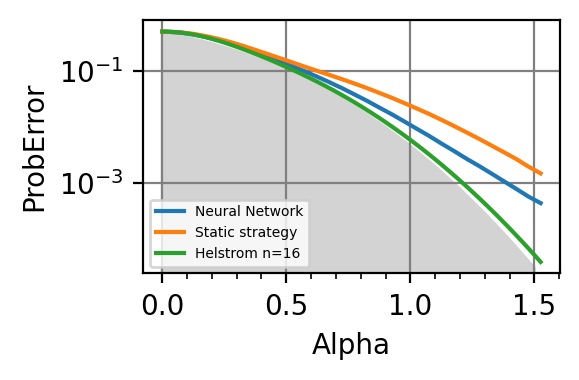

In [184]:
if num_steps==4 or num_steps==8:
    if static_flag:
        pu.plot_multiples(
            [prec_nn_df, prec_static_df, prec_dict_fabio[f'het{num_steps}'],
            prec_dict_fabio[f'ph{num_steps}'], helstrom_limited], 
            "Alpha", "ProbError", 
            ["Neural Network", "Static strategy", "Heterodyne",
            "Photon counting", f"Helstrom n={num_steps}"],
            figsize=(3, 2), dpi=200,
            legend_location="lower left",
            #title="Precision",
            path=img_dir,
            lower_bound_df=df_ultimate_heltrom,
        )
    else:
        pu.plot_multiples(
            [prec_nn_df, prec_dict_fabio[f'het{num_steps}'],
            prec_dict_fabio[f'ph{num_steps}'], helstrom_limited], 
            "Alpha", "ProbError", 
            ["Neural Network", "Heterodyne",
            "Photon counting", f"Helstrom n={num_steps}"],
            figsize=(3, 2), dpi=200,
            legend_location="lower left",
            #title="Precision",
            path=img_dir,
            lower_bound_df=df_ultimate_heltrom,
        )
else:
    if static_flag:
        pu.plot_multiples(
        [prec_nn_df, prec_static_df, helstrom_limited], 
        "Alpha", "ProbError", 
        ["Neural Network", "Static strategy", f"Helstrom n={num_steps}"],
        figsize=(3, 2), dpi=200,
        legend_location="lower left",
        #title="Precision",
        path=img_dir,
        lower_bound_df=df_ultimate_heltrom,
        )
    else:
        pu.plot_multiples(
        [prec_nn_df, helstrom_limited], 
        "Alpha", "ProbError", 
        ["Neural Network", f"Helstrom n={num_steps}"],
        figsize=(3, 2), dpi=200,
        legend_location="lower left",
        #title="Precision",
        path=img_dir,
        lower_bound_df=df_ultimate_heltrom,
        )

### Trajectories

In [171]:
###############
traj_num = 5
base = 40
static = False
###############

In [112]:
if static:
    traj_num = 1

In [113]:
name_traj = generate_name(batchsize, num_steps, num_steps+1)
data_df = pd.read_csv(
    f'./dolinar/data/training_loss_{training_loss}/{name_traj}_ext.csv',
)
data_df[r'Theta mod $\pi$'] = data_df['Theta']%pi
data_df['MeasStep'] = num_steps*data_df['MeasStepOverNumStep']

FileNotFoundError: [Errno 2] No such file or directory: './dolinar/data/training_loss_6/dolinar_batchsize_4096_num_steps_5_max_resources_5.00_ll_False_cl_False_loss_0_ext.csv'

In [ ]:
data_df = data_df[data_df['MeasStep']!=num_steps]

In [ ]:
trajectory_list = [data_df[data_df['Estimation']==i+base] for i in range(traj_num)]

In [ ]:
omega_list = [f"{trajectory_list[i]['alpha'].values[0]:.2f}" for i in range(traj_num)]

In [ ]:
pu.plot_multiples(
    trajectory_list, "MeasStep", r"Theta mod $\pi$",
    omega_list, log_scale=False, title="Control strategy",
    figsize=(3, 2.2), dpi=200,
    legend_location="upper left",
    path=img_dir,
)

In [ ]:
pu.plot_multiples(
    trajectory_list, "NumPhotons", r"Theta mod $\pi$",
    omega_list, log_scale=False, title="Control strategy",
    figsize=(3, 2.2), dpi=200,
    legend_location="upper left",
    path=img_dir,
)

### Small plots

In [ ]:
pu.plot_3_values(
    data_df, 
    "Mean_AlphaPlus", r"Theta mod $\pi$", color="MeasStepOverNumStep",
    figsize=(2, 2), dpi=200, 
    path=img_dir,
)

In [ ]:
pu.plot_3_values(
    data_df, 
    "Mean_AlphaMinus", r"Theta mod $\pi$", color="MeasStepOverNumStep",
    figsize=(2, 2), dpi=200, 
    path=img_dir,
)

In [ ]:
pu.plot_3_values(
    data_df, 
    "PsiPlus", r"Theta mod $\pi$", color="MeasStepOverNumStep",
    figsize=(2, 2), dpi=200, 
    path=img_dir,
)

In [ ]:
pu.plot_3_values(
    data_df, 
    "PsiMinus", r"Theta mod $\pi$", color="MeasStepOverNumStep",
    figsize=(2, 2), dpi=200, 
    path=img_dir,
)

In [ ]:
pu.plot_3_values(
    data_df, 
    "ProbPlus", r"Theta mod $\pi$", color="MeasStepOverNumStep",
    figsize=(2, 2), dpi=200, 
    path=img_dir,
)